In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, Model

In [19]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

#step 1

In [21]:
# Load dataset
df = pd.read_csv('/content/IMDB_balanced_dataset.csv')
texts = df['review'].tolist()
labels = [1 if s == 'positive' else 0 for s in df['sentiment']]

# Clean HTML tags
texts = [re.sub(r'<br\s*/?>', ' ', text) for text in texts]

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [29]:
df.head()

,review,sentiment
0,I would like to tell you just a few things bef...,positive
1,This is a VERY underrated movie to say the lea...,positive
2,Du Rififi Chez Les Hommes/Rififi(1955) can on ...,positive
3,"""Beowulf"" is like a very bad game : no charact...",negative
4,It seems on the surface to be a romantic _plan...,negative


#Step 2

In [22]:
max_vocab = 20000  # Vocabulary size
max_seq_len = 256   # Sequence length

# Define text vectorization layer
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab,
    output_sequence_length=max_seq_len,
    output_mode='int'
)

# Adapt to training data
vectorizer.adapt(train_texts)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(32)

#Step 3

In [24]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super().__init__()
        self.max_len = max_len
        self.embed_dim = embed_dim

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super().__init__()
        self.max_len = max_len
        self.embed_dim = embed_dim

        # Precompute positional encodings
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, embed_dim, 2) * (-np.log(10000.0) / embed_dim))
        pe = np.zeros((max_len, embed_dim))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)  # Shape: (1, max_len, embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pe[:, :seq_len, :]
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)  # Shape: (1, max_len, embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pe[:, :seq_len, :]

#Step 4

In [25]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training=False):
        # Multi-head attention
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feedforward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Step 5

In [26]:
embed_dim = 128    # Embedding dimension
num_heads = 4      # Number of attention heads
ff_dim = 256       # Feedforward dimension

# Input layer (raw text)
inputs = tf.keras.Input(shape=(), dtype=tf.string)

# Vectorization -> Embedding -> Positional Encoding -> Transformer
x = vectorizer(inputs)  # Convert text to integer sequences
x = tf.keras.layers.Embedding(input_dim=max_vocab, output_dim=embed_dim)(x)
x = PositionalEncoding(max_seq_len, embed_dim)(x)
x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 256)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 256, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 256, 128)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 256, 128)       │       330,240 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,890,369 (11.03 MB)

 Trainable params: 2,890,369 (11.03 MB)

 Non-trainable params: 0 (0.00 B)

# Step 6

In [27]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.5080 - loss: 1.0447 - val_accuracy: 0.4500 - val_loss: 1.3295
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4403 - loss: 1.0647 - val_accuracy: 0.5500 - val_loss: 0.8034
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5597 - loss: 0.7350 - val_accuracy: 0.4500 - val_loss: 0.8443
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4773 - loss: 0.8013 - val_accuracy: 0.5500 - val_loss: 0.6882
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5227 - loss: 0.6953 - val_accuracy: 0.5500 - val_loss: 0.6878
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5290 - loss: 0.6741 - val_accuracy: 0.4500 - val_loss: 0.7377
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4793 - loss: 0.7091 - val_accuracy: 0.4500 - val_loss: 0.6921
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6648 - loss: 0.6762 - val_accuracy: 0.5500 - val_loss: 0.6847

# step 7

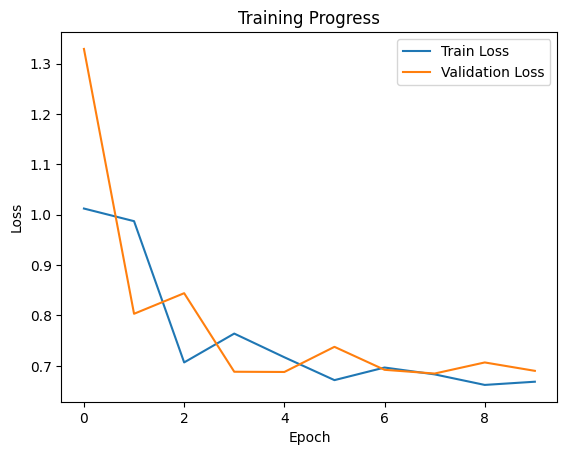

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()